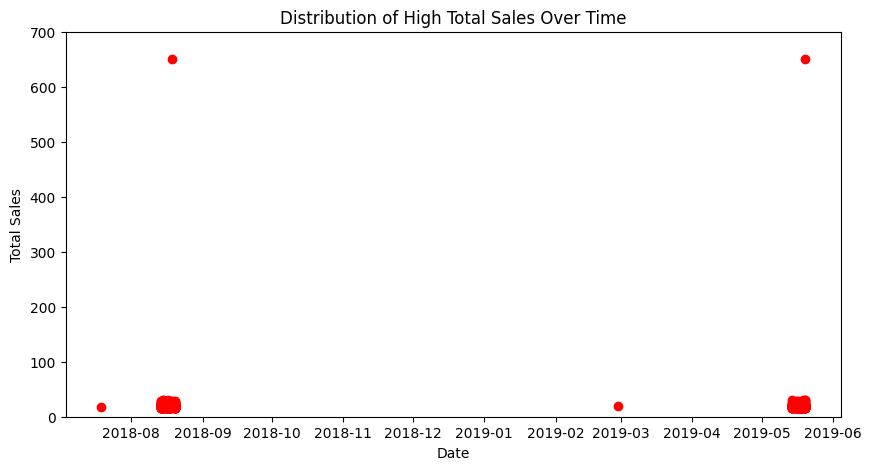

Top 10 Highest Total Sales:
             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762  2018-08-19        226          226000  226201         4   
69763  2019-05-20        226          226000  226210         4   
5179   2018-08-15         94           94148   93390        14   
55558  2019-05-14        190          190113  190914        14   
69496  2018-08-15         49           49303   45789        14   
117850 2019-05-19        194          194308  194516        14   
150683 2019-05-20        118          118021  120799        14   
171815 2018-08-17         24           24095   20797        14   
184969 2019-05-20         44           44350   40394        14   
72     2018-08-19         96           96203   96025         7   

                                     PROD_NAME  PROD_QTY  TOT_SALES  
69762         Dorito Corn Chp     Supreme 380g       200      650.0  
69763         Dorito Corn Chp     Supreme 380g       200      650.0  
5179    Smiths Crnkle Chip  Orgnl B

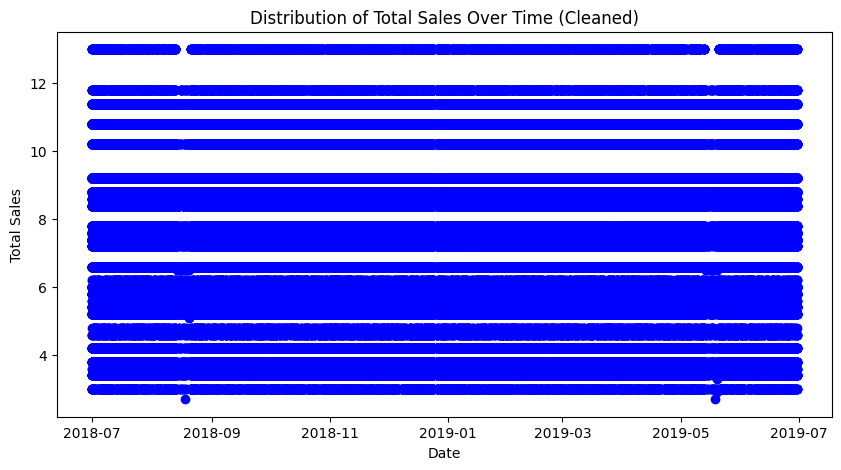

   LYLTY_CARD_NBR  TOTAL_SPENDING
0            1000             6.0
1            1010             8.8
2            1011             6.2
3            1013             4.2
4            1025             6.0
   LYLTY_CARD_NBR  AVERAGE_QTY
0            1000          2.0
1            1010          2.0
2            1011          2.0
3            1013          2.0
4            1025          2.0


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from datetime import datetime, timedelta

# Load data
purchase_behaviour_data = pd.read_csv('QVI_purchase_behaviour.csv')
transaction_data = pd.read_excel('QVI_transaction_data.xlsx', sheet_name='in')

# Function to identify outliers using Z-score
def z_score_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data.select_dtypes(include=np.number)))
    outliers = (z_scores > threshold).any(axis=1)
    return data[outliers]

# Identify outliers
purchase_behaviour_data_outliers = z_score_outliers(purchase_behaviour_data)
transaction_data_outliers = z_score_outliers(transaction_data)

# Function to detect outliers using IQR
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

# Apply the function to 'PROD_QTY' and 'TOT_SALES'
prod_qty_outliers = detect_outliers_iqr(transaction_data, 'PROD_QTY')
tot_sales_outliers = detect_outliers_iqr(transaction_data, 'TOT_SALES')

# Convert Excel serial date to datetime
def excel_date_to_datetime(excel_serial_date):
    excel_epoch = datetime(1899, 12, 30)  # Excel's epoch start (not 1900 due to a historical error)
    delta = timedelta(days=excel_serial_date)
    return excel_epoch + delta

transaction_data['DATE'] = transaction_data['DATE'].apply(excel_date_to_datetime)

# Plotting the distribution of high total sales over time
plt.figure(figsize=(10, 5))
plt.scatter(transaction_data.loc[transaction_data['TOT_SALES'] > 15, 'DATE'], 
            transaction_data.loc[transaction_data['TOT_SALES'] > 15, 'TOT_SALES'], color='red')
plt.title('Distribution of High Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.ylim(0, 700)  # Adjusting the Y-axis limit for clarity
plt.show()

# Display the top 10 highest total sales
top_10_highest_sales = transaction_data.nlargest(10, 'TOT_SALES')
print("Top 10 Highest Total Sales:")
print(top_10_highest_sales)

# Display the top 10 lowest total sales
top_10_lowest_sales = transaction_data.nsmallest(10, 'TOT_SALES')
print("\nTop 10 Lowest Total Sales:")
print(top_10_lowest_sales)

# Feature Engineering
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)g')
transaction_data['BRAND_NAME'] = transaction_data['PROD_NAME'].str.split().str[0]

print(transaction_data[['PACK_SIZE', 'BRAND_NAME']].head())

# Remove Outliers
transaction_data_clean = transaction_data[~transaction_data.index.isin(prod_qty_outliers.index)]
transaction_data_clean = transaction_data_clean[~transaction_data_clean.index.isin(tot_sales_outliers.index)]

# Re-plotting without extreme outliers
plt.figure(figsize=(10, 5))
plt.scatter(transaction_data_clean['DATE'], 
            transaction_data_clean['TOT_SALES'], color='blue')
plt.title('Distribution of Total Sales Over Time (Cleaned)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Calculate total spending per customer
customer_spending = transaction_data_clean.groupby('LYLTY_CARD_NBR')['TOT_SALES'].sum().reset_index(name='TOTAL_SPENDING')

# Calculate average product quantity per transaction
average_qty = transaction_data_clean.groupby('LYLTY_CARD_NBR')['PROD_QTY'].mean().reset_index(name='AVERAGE_QTY')

print(customer_spending.head())
print(average_qty.head())